# Modèle d'Ising

Un système magnétique peut-être décrit de façon simple avec l'Hamiltonien suivant (modèle d'Heisenberg):
\begin{equation}
    H = -\frac{4}{h^2}\sum_{i<j} J_{ij} \vec{s}_i \cdot \vec{s}_j - \gamma\vec{B}\cdot\sum_i \vec{s}_i
\end{equation}
Dans cet exercice, nous allons nous intéresser à un modèle encore plus simple: celui d'un ensemble de spin 1/2 et ne considérer que l'intéraction entre les spins voisins les plus proches. En écrivant $\vec{s}_i = \frac{\hbar}{2}S_i$ ($S_i=\pm1$), on obtient le modèle d'Ising décrit par l'Hamiltonien:
\begin{equation}
    H = -J\sum_{\langle i,j\rangle} S_i S_j - \mu B \sum_i S_i
\end{equation}
où la notation $\langle i,j\rangle$ denote la somme sur les paires des plus proches voisins. 

Nous allons dans cet exercice simuler ce système à l'aide d'un algorithme appelé "Metrolopolis". Celui-ci est détaillé sur la page wikipedia dédié au model d'Ising. https://en.wikipedia.org/wiki/Ising_model . Nous prendrons un champ magnétique nul.

L'état du système sera représenté par un tableau de taille $N\times N$. Nous utiliserons des conditions périodiques (i.e. le spin à la position $(N-1, j)$ est couplé au spin à la position $(0, j)$, etc.

1. Écrire une fonction `energy(state)` qui retourne l'énergie totale du système magnétique dans l'état 'state'.

2. Écrire une fonction `delta_energy(state, i, j)` qui retourne la difference d'énergie induite par le flipping du spin de coordonnees `(i, j)`. Nous rappellons que seule l'intéraction entre plus proches voisins est considérée.

3. Écrire une fonction `metropolis(state, beta, M)` qui retourne l'état du système magnétique après avoir implémenté M fois l'algorithme de Metrolopolis. Une réalisation de l'algorithme correspond à choisir un point de manière aléatoire, à calculer la différence d'énergie induite par le flip de celui-ci. Si cette énergie est négative, alors on considère que le spin flip. Si la différence d'énergie est positive, on autorise le spin flip selon la probabilité: $e^{-\beta \Delta E}$. 

4. Afficher l'image pour $\beta=1$, après 1000, 1 000 000, 100 000 000 itérations. Vous pouvez aussi faire une animation. On prendra comme état initial, 300x300 spins de valeur aléatoire $\pm 1$. Il faudra utiliser numba.
   
5. Nous allons regarder l'énergie moyenne du système. Modifier votre fonction metropolis, de façon à pouvoir enregistrer l'énergie moyenne du système pendant l'évolution. Pour éviter des problèmes de mémoires, nous vous conseillons de l'enregistrer uniquement tous les $N^2$ réalisations.

   Tracer l'énergie du système au cours du temps. Observer le temps de convergence du système (on prendra $\beta=1$, $\beta=0.2$ et $\beta=0.1$). En plus de la convergence, qu'observez-vous pour $\beta=0.2$ ? 

6. Tracer l'énergie moyenne en fonction de $\beta$. Vous pourrez aussi accélérer votre calcul en l'évaluant sur plusieurs noyaux de votre ordinateur, à l'aide du décorateur: `@jit(parallel=True)` et de la boucle `for beta in numba.prange(xxx):`. 

7. De même, tracer les fluctuations d'énergie en fonction $\beta$

8. Comme vous l'avez vu en cours de Physique Statistique, il existe une solution analytique au modèle d'Ising en deux dimensions:

![alt text](solution_ising.JPG "Title")

   Comment calculer l'énergie moyenne du système à partir de la fonction de partition $Z$ ? Evaluez numériquement cette expression et comparez à votre simulation metrolopolis.

   Si vous avez le temps, même question pour les fluctuations d'énergie

9. La transition de phase a lieu pour $T$ qui vérifie:
\begin{equation}
    \sinh\left(\frac{2J}{kT}\right)= 1
\end{equation}
Résolvez cette equation numériquement (on pourra utiliser la fonction root de scipy) et comparez aux résultats de la question précédente.


------------------------------------------------

## Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba
from numba import jit

In [8]:

J = 2
N = 300

@jit
def energy(state):
    E = 0
    for i in range(N):
        for j in range(N):
            E += -J*state[i, j]* state[(i+1)%N, j]
            E += -J*state[i, j]* state[i, (j+1)%N]

    return E

@jit
def delta_energy(state, i, j):
    delta_E = 2*J*state[i, j]*(state[(i+1)%N, j] + state[i, (j+1)%N] + 
                                state[(i-1)%N, j] + state[i, (j-1)%N])
    return delta_E

@jit
def metropolis(state, beta, M):
    state = state.copy()
    nb_output = M//(N*N)
    output = np.zeros(nb_output)
    s = 0
    for m in range(M):
        i0 = np.random.randint(N)
        j0 = np.random.randint(N)
        delta_E = delta_energy(state, i0, j0)
        if delta_E<0:
            state[i0, j0] = -state[i0, j0]
        else:
            if np.random.rand() < np.exp(-beta*delta_E):
                state[i0, j0] = -state[i0, j0]
        if m%(N**2)==0:
            output[s] = energy(state)
            s += 1
    return state, output[:s]
            

def create_initial_state(N):
    ini_state = 2*(np.random.rand(N, N)>.5) - 1
    return ini_state

In [10]:
ini_state = create_initial_state(N)
out_stateA, _ = metropolis(ini_state, beta=1, M=1000)
out_stateB, _ = metropolis(ini_state, beta=1, M=1000000)
out_stateC, _ = metropolis(ini_state, beta=1, M=100000000)

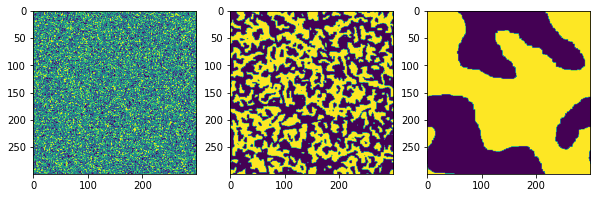

In [11]:
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.imshow(out_stateA)
ax2.imshow(out_stateB)
ax3.imshow(out_stateC)

In [12]:
ini_state = create_initial_state(N)

beta = 0.25
ini_state, _ = metropolis(ini_state, beta=beta, M=100000000)

out = []
for _ in range(200):
    ini_state, _ = metropolis(ini_state, beta=beta, M=1000000)
    out.append(ini_state)

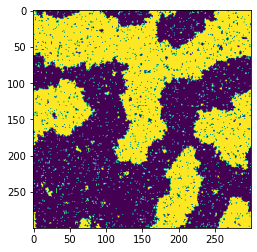

In [14]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()

def animate(i):
    ax.cla()
    ax.imshow(out[i])

ani = FuncAnimation(fig, animate, frames=len(out), interval=20)

#HTML(ani.to_jshtml())

In [15]:
ini_state = create_initial_state(N)

state, energyA = metropolis(ini_state, beta=1, M=100000000)
state, energyB = metropolis(ini_state, beta=0.22, M=100000000)
state, energyC = metropolis(ini_state, beta=0.1, M=100000000)

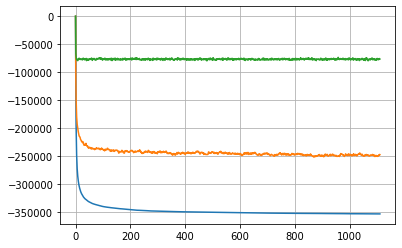

In [17]:
fig = plt.figure()
ax = fig.subplots(1, 1)

ax.plot(energyA, label=r'$\beta=1')
ax.plot(energyB, label=r'$\beta=1')
ax.plot(energyC, label=r'$\beta=1')

ax.grid()

ax.legend()

On observe des fluctuations importantes pour la courbe $\beta=0.2$

In [18]:
Tbeta = np.logspace(-2, 0.3, 201)

@jit(parallel=True)
def metropolis_over_beta(Tbeta, M=200000000):
    Nbeta = len(Tbeta)
    res = np.zeros((Nbeta, 1000))
    for i in numba.prange(Nbeta) :
        beta = Tbeta[i]
        ini_state = 2*(np.random.rand(N, N)>.5) - 1
        state, output = metropolis(ini_state, beta, M)
        res[i,:] = output[-1000:]
    return res

In [19]:
res = metropolis_over_beta(Tbeta)

Text(0.5, 0, 'T')

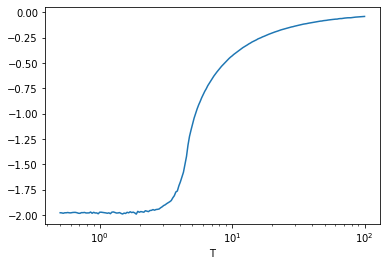

In [21]:
fig = plt.figure()
ax = fig.subplots(1, 1)

ax.semilogx(1/Tbeta, res[:, -100:].mean(axis=1)/(2*N**2))
ax.set_xlabel('T')

Text(0.5, 0, 'T')

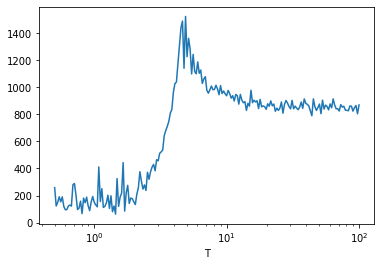

In [20]:
fig = plt.figure()
ax = fig.subplots(1, 1)

ax.semilogx(1/Tbeta, res[:, -500:].std(axis=1))
ax.set_xlabel('T')

L'énergie moyenne est donnée par : 
\begin{equation}
\left<E\right> = -\frac{\partial\ln Z}{\partial \beta}
\end{equation}

Les fluctuations d'énergie par la dérivée seconde.

In [22]:
from numpy import pi, sin, cos, cosh, sinh, log, exp, sqrt

def integrande(theta, beta, J):
    x = 2*sinh(2*beta*J)/cosh(2*beta*J)**2
    return 1/(2*pi)*log((1+sqrt(1-x**2*sin(theta)**2))/2)

def Log_Z(beta, J, N):
    Ntheta = 1000
    Ttheta = np.arange(Ntheta+1)*pi/Ntheta
    dtheta = Ttheta[1]-Ttheta[0]
    I = np.zeros_like(beta)
    for theta in Ttheta:
        I += integrande(theta, beta, J)*dtheta
    return N*(log(2*cosh(2*beta*J))+I)
    
def mean_energy(beta, J, N):
    LZ = np.array(Log_Z(beta, J, N))
    return -(LZ[1:]-LZ[:-1])/(beta[1:]-beta[:-1])/(2*J*N), (beta[1:]+beta[:-1])/2

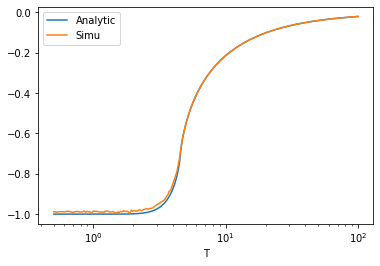

In [24]:
#J = 1
#N = 300

Tbeta2 = np.logspace(-2, 0.3, 1000)  

analytic_energy, Tbeta_diff = mean_energy(Tbeta2, J, N)

fig = plt.figure()
ax = fig.subplots(1, 1)


ax.semilogx(1/Tbeta_diff, analytic_energy, label='Analytic')
ax.semilogx(1/Tbeta, res[:, -100:].mean(axis=1)/(2*J*N**2),label='Simu')
ax.set_xlabel('T')
ax.legend()

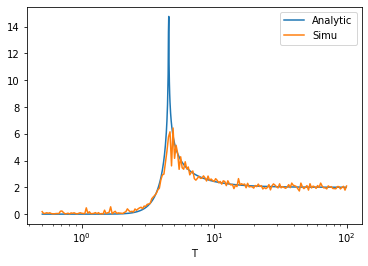

In [26]:
fluctuation_enery = (analytic_energy[1:] - analytic_energy[:-1])/(Tbeta_diff[1:] - Tbeta_diff[:-1])

fig = plt.figure()
ax = fig.subplots(1, 1)


ax.semilogx(1/Tbeta_diff[1:], -fluctuation_enery, label='Analytic')
ax.semilogx(1/Tbeta, res[:, -500:].var(axis=1)/(2*J*N**2),label='Simu')

ax.set_xlabel('T')
ax.legend()

In [27]:
from scipy.optimize import root

In [28]:
def fun(beta, J):
    return np.sinh(2*beta*J)-1
    
sol = root(fun, 1, args=(J,))
sol.x

array([0.2203434])

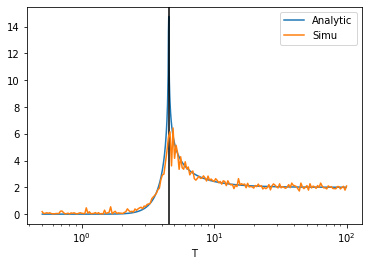

In [32]:
fig = plt.figure()
ax = fig.subplots(1, 1)


ax.semilogx(1/Tbeta_diff[1:], -fluctuation_enery, label='Analytic')
plt.axvline(1/sol.x, color='k')

ax.semilogx(1/Tbeta, res[:, -500:].var(axis=1)/(2*J*N**2),label='Simu')





ax.set_xlabel('T')
ax.legend()